In [7]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import numpy as np
import torch
import jax
import jax.numpy as jnp
import networkx as nx
import matplotlib.pyplot as plt

from ott import utils
from ott.geometry import geometry
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.problems.linear import linear_problem
import tqdm

## OT for GNN Fusion

### Sample Data

In [8]:
# Prepare a possible input for OT problem
import random 

# Create as many graphs as there are data points for generating activations
n_data_graphs = 5
data_graphs = []
X_size = 20 # Corresponds to numbers of rows in convolution weight matrix of source model
Y_size = 20 # Corresponds to numbers of rows in convolution weight matrix of target model
X = [] # Activations for source
Y = [] # Activations for target
a = torch.ones(X_size)/X_size
b = torch.ones(Y_size)/Y_size

for i in range(n_data_graphs):
    num_nodes = random.randint(5,10)
    edge_indices_1 = [j for j in range(num_nodes)]
    edge_indices_2 = [random.randint(0,num_nodes-1) for j in range(num_nodes)]
    graph = dgl.graph((edge_indices_1, edge_indices_2), num_nodes=num_nodes)
    data_graphs.append(graph)

for i in range(X_size):
    x = []
    for graph in data_graphs:
        graph_X = graph.clone()
        num_nodes = graph_X.num_nodes()
        #graph_X.ndata["Feature"] = torch.randn(num_nodes,1)
        graph_X.ndata["Feature"] = torch.ones(num_nodes,1)*i
        x.append(graph_X)
    X.append(x)

for i in range(Y_size):
    y = []
    for graph in data_graphs:
        graph_Y = graph.clone()
        num_nodes = graph_Y.num_nodes()
        #graph_Y.ndata["Feature"] = torch.randn(num_nodes,1)
        graph_Y.ndata["Feature"] = torch.ones(num_nodes,1)*i*1.2
        y.append(graph_Y)
    Y.append(y)


### Setup Cost Matrix

In [9]:
def _cost_fn_l1(x, y):
    n = len(x)
    assert n == len(y)
    cost = 0
    for i in range(n):
        cost += torch.norm(x[i].ndata["Feature"] - y[i].ndata["Feature"], dim=0)
    return cost

In [10]:
def _get_cost_matrix(X, Y, cost_fn):
    """
    X: list of dgl graphs
    Y: list of dgl graphs
    """
    cost_matrix = np.zeros((len(X),len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            cost_matrix[i][j] = cost_fn(X[i], Y[j])
    return jnp.array(cost_matrix)

In [11]:
def _get_current_transport_map(a, b, X, Y, cost_fn, epsilon = None, tau_a = 1, tau_b = 1, low_rank = False, verbose = False):
    """
    Solve optimal transport problem for activation support for GNN Fusion
    """
    # Define Geometry
    cost_matrix = _get_cost_matrix(X, Y, cost_fn)
    geom = geometry.Geometry(cost_matrix=cost_matrix, epsilon=epsilon) 

    # Define Problem
    ot_prob = linear_problem.LinearProblem(geom, tau_a=tau_a, tau_b=tau_b)

    # Solve Problem       
    with tqdm.tqdm() as pbar:
        progress_fn = utils.tqdm_progress_fn(pbar)

        if low_rank == True:
            solve_fn = sinkhorn_lr.LRSinkhorn(rank=int(min(len(x), len(y)) / 2), progress_fn=progress_fn)
        else:
            solve_fn = sinkhorn.Sinkhorn(progress_fn=progress_fn)
            
        ot = jax.jit(solve_fn)(ot_prob)

    if verbose:
        print(
        "\nSinkhorn has converged: ",
        ot.converged,
        "\n",
        "-Error upon last iteration: ",
        ot.errors[(ot.errors > -1)][-1],
        "\n",
        "-Sinkhorn required ",
        jnp.sum(ot.errors > -1),
        " iterations to converge. \n",
        "-Entropy regularized OT cost: ",
        ot.reg_ot_cost,
        "\n",
        "-OT cost (without entropy): ",
        jnp.sum(ot.matrix * ot.geom.cost_matrix),
        )

    return ot

100%|██████████| 200/200 [00:00<00:00, 434.56it/s, error: 3.000876e-01]


Sinkhorn has converged:  False 
 -Error upon last iteration:  0.30008757 
 -Sinkhorn required  200  iterations to converge. 
 -Entropy regularized OT cost:  8.802576 
 -OT cost (without entropy):  5.010608


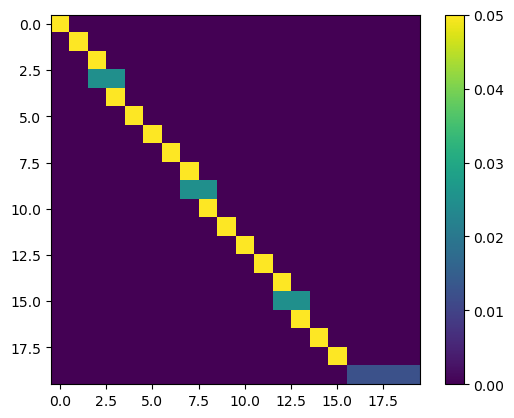

In [12]:
ot = _get_current_transport_map(a, b, X, Y, cost_fn = _cost_fn_l1, epsilon=0.001, verbose=True)
plt.imshow(ot.matrix)
plt.colorbar()

## DGL Graph Objects

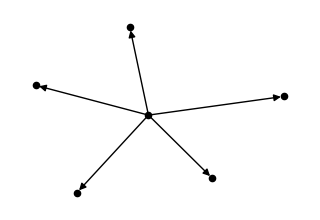

In [13]:
# Create dgl graph
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}

# Assign a 3-dimensional node feature vector for each node.
g.ndata["x"] = torch.randn(6, 3)
g.ndata["x"][0] = torch.tensor([1, 2, 0])

# Plot graph
G = dgl.to_networkx(g)
plt.figure(figsize=[3,2])
nx.draw(G, **options)